In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import tensorflow as tf

path_parent = os.path.dirname(os.getcwd())

if os.getcwd()[-8:] != 'FYP-Code':
    os.chdir(path_parent)

print(os.getcwd())

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})

/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code


In [4]:
from helper.synthesis import generate_pointwise_data

In [5]:
generate_pointwise_data()

100%|██████████| 57404/57404 [00:00<00:00, 224339.64it/s]


Data successfully generated!


<AxesSubplot: ylabel='Density'>

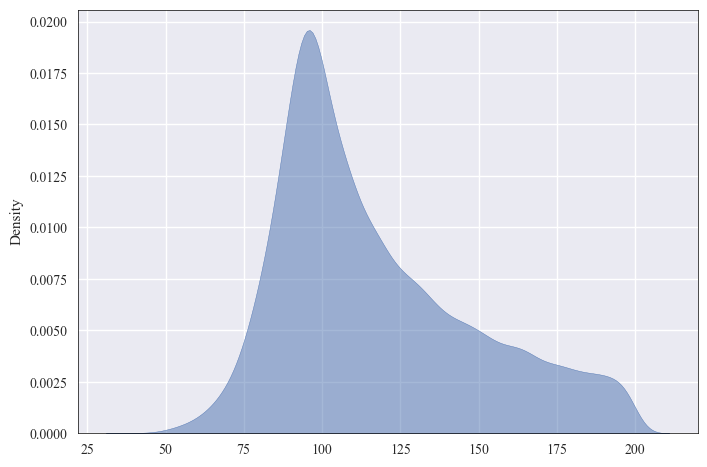

In [6]:
import seaborn as sns

from analysis.pointwise.model import load_data

params_range_train, params_range_test, price_train, price_test = load_data()

sns.kdeplot(price_train, fill = True, alpha = 0.5)

array([151.40081719, 139.31221331, 100.57406844, ...,  88.0148755 ,
       122.76258062, 118.16108701])